<img align="right" src="../img/notebook_banner_siegel.png">

# Calculating band indices


* [**Sign up to eo2cube**](https://google.com) to try this notebook in your browser
* **Compatibility:** Notebook currently compatible the eo2cube environmenst
* **Products used:** 
[s2_l2a_](https://sentinel.esa.int/web/sentinel/missions/sentinel-2)

Many thanks to Digital Earth Australia and all participants (Krause, C., Dunn, B., Bishop-Taylor, R., Adams, C., Burton, C., Alger, M., Chua, S., Phillips, C., Newey, V., Kouzoubov, K., Leith, A., Ayers, D., Hicks, A., DEA Notebooks contributors 2021. Digital Earth Australia notebooks and tools repository. Geoscience Australia, https://doi.org/10.26186/145234). This notebooks uses the DEA notebook structure, ideas and algorithms developed by DEA.

## Background
Remote sensing indices are combinations of spectral bands used to highlight features in the data and the underlying landscape.
Using Analysis-ready satellite data, we can easily calculate a wide range of remote sensing indices that can be used to assist in mapping and monitoring features like vegetation and water consistently through time, or as inputs to machine learning or classification algorithms.

## Description
This notebook demonstrates how to:
 
* Calculate an index manually using `xarray`
* Calculate one or multiple indices using the function `calculateindices` from `tools/bandindices.py`
* Calculate indices while dropping original bands from a dataset
* Calculate an index in-place without duplicating original data to save memory on large datasets
 
***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import sys
import geopandas as gpd
import xarray as xr
#from tools.deawater import wofs_classify

from tools.plotting import rgb
from tools.bandindices import s2_indices


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='indices')

### Load vectorfile

In [3]:
oanob = gpd.read_file('vector/oanob_dam.geojson')

In [4]:
#extract coordinates
minx = oanob.bounds.iloc[0,0]
maxx = oanob.bounds.iloc[0,2]
miny = oanob.bounds.iloc[0,1]
maxy = oanob.bounds.iloc[0,3]


In [5]:
oanob

,id,geometry
0,None,"MULTIPOLYGON (((87398.318 7412240.790, 87208.5..."


## Create a query and load satellite data
To demonstrate how to compute a remote sensing index, we first need to load in a time series of satellite

In [6]:
dataset = dc.load(product = 's2_l2a_namibia', # works also with timestamp
                          x=(minx, maxx),
                          y=(miny, maxy),
                          crs='EPSG:32734',
                          time=('2020-01-01', '2020-01-31'),
                          #resolution=(-100,100),
                          #resampling={'*': 'cubic', 'scl': 'med'},
                          group_by='solar_day')

In [7]:
dataset

<xarray.Dataset>
Dimensions:          (time: 12, x: 864, y: 704)
Coordinates:
  * time             (time) datetime64[ns] 2020-01-02T09:06:48 ... 2020-01-30...
  * y                (y) float64 7.419e+06 7.419e+06 ... 7.412e+06 7.412e+06
  * x                (x) float64 8.720e+04 8.722e+04 ... 9.582e+04 9.584e+04
    spatial_ref      int32 32734
Data variables: (12/13)
    coastal_aerosol  (time, y, x) int16 774 774 774 774 844 844 ... 0 0 0 0 0 0
    blue             (time, y, x) int16 959 907 955 857 937 941 ... 0 0 0 0 0 0
    green            (time, y, x) int16 1326 1352 1396 1294 1372 ... 0 0 0 0 0
    red              (time, y, x) int16 1874 1832 1858 1730 1918 ... 0 0 0 0 0
    red_edge1        (time, y, x) int16 2165 2165 2067 2067 2108 ... 0 0 0 0 0
    red_edge2        (time, y, x) int16 2194 2194 2150 2150 2158 ... 0 0 0 0 0
    ...               ...
    nir              (time, y, x) int16 2220 2216 2220 2082 2170 ... 0 0 0 0 0
    narrow_nir       (time, y, x) int16 2419 2419 2388 2388 2372 ... 0 0 0 0 0
    water_vapour     (time, y, x) int16 2328 2328 2328 2328 2460 ... 0 0 0 0 0
    swir1            (time, y, x) int16 4083 4083 3930 3930 3843 ... 0 0 0 0 0
    swir2            (time, y, x) int16 4074 4074 3899 3899 3877 ... 0 0 0 0 0
    scl              (time, y, x) uint8 5 5 5 5 5 5 5 5 5 ... 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:32734
    grid_mapping:  spatial_ref

### Mask your data using the scene classification
Here you will find a description of the Sentinel-2 [scene classification](https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm)

In [10]:
# thats python, one line, one mask
s2_clean_mask = dataset.scl.isin([4, 5, 6, 7])
s2_clean_mask

<xarray.DataArray 'scl' (time: 12, y: 704, x: 864)>
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * time         (time) datetime64[ns] 2020-01-02T09:06:48 ... 2020-01-30T09:...
  * y            (y) float64 7.419e+06 7.419e+06 ... 7.412e+06 7.412e+06
  * x            (x) float64 8.720e+04 8.722e+04 ... 9.582e+04 9.584e+04
    spatial_ref  int32 32734

In [11]:
# booleans to integer, mask to dataset
mask = s2_clean_mask.astype('uint8')
dataset['mask'] = mask.astype('uint8')
#dataset

#### The mask can be used for a evaluating the cloud percentage

In [12]:
# Not validated code! Maybe sth still wrong, or there are really so less clouds
#
times = list(dataset.time.values)
percentage_list = list((((dataset.sum(dim=['x','y'])/
                          ((dataset.dims)['y']*(dataset.dims)['x']))
                        .mask).values)*100)
data = {"Acquisition time": times,
            "Cloud free pixel[%]": percentage_list}
s2_cct = pd.DataFrame(data=data, columns = ["Acquisition time", "Cloud free pixel[%]"])
s2_cct

,Acquisition time,Cloud free pixel[%]
0,2020-01-02 09:06:48,99.463055
1,2020-01-05 09:16:45,0.000000
2,2020-01-07 09:06:48,99.619239
3,2020-01-10 09:16:45,0.000000
4,2020-01-12 09:06:48,88.604634
5,2020-01-15 09:16:44,0.000000
6,2020-01-17 09:06:47,99.823430
7,2020-01-20 09:16:44,0.000000
8,2020-01-22 09:06:47,99.368522
9,2020-01-25 09:16:43,0.000000


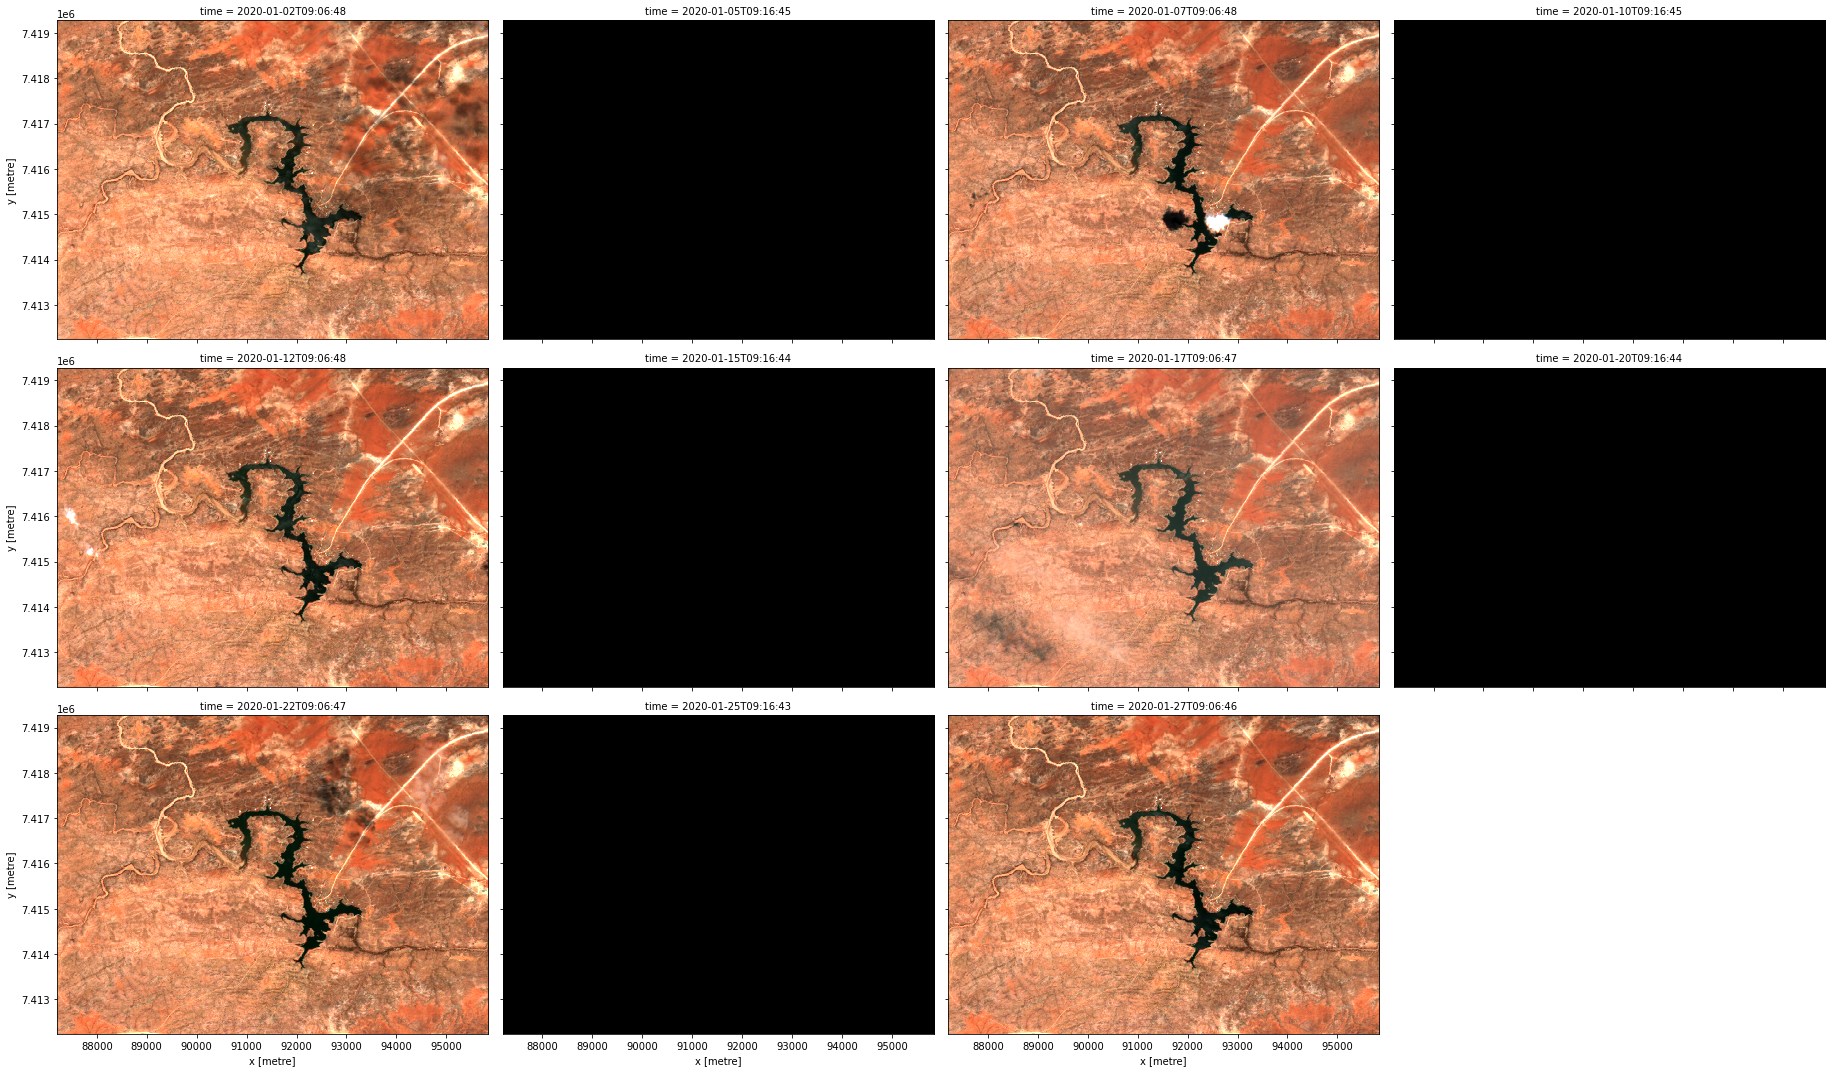

In [13]:
rgb(dataset, index=[0,1,2,3,4,5,6,7,8,9,10], size=5,
   bands=['red_edge1','green','blue'])

In [14]:
# Not validated code! 
cloud_percent = 0.001
#
clean_dataset=dataset.sel(time=pd.to_datetime(
((dataset.sum(dim=['x','y'])/
  ((dataset.dims)['y']*(dataset.dims)['x']))
 .time.where(
     ((dataset.sum(dim=['x','y'])/
  ((dataset.dims)['y']*(dataset.dims)['x'])).mask) > cloud_percent,drop=True))
.values.tolist()))

In [15]:
rgb(clean_dataset, index=[0,1,2,3,4,5,6,7,8,9,10], size=5,
   bands=['red_edge1','green','blue'])

IndexError: index 6 is out of bounds for axis 0 with size 6

In [ ]:
rgb?

#### Cloud cleaning

In [16]:
clean_dataset = clean_dataset.where(s2_clean_mask)

In [17]:
rgb(clean_dataset, index=[0,1,2,3,4,5,6,7,8,9,10], size=5,
   bands=['red_edge1','green','blue'], robust=True)

IndexError: index 6 is out of bounds for axis 0 with size 6

In [18]:
# Not validated code! sth. still wrong, since 100 % clouds isnt achieved even for NA data
times = list(clean_dataset.time.values)
percentage_list = list((((clean_dataset.sum(dim=['x','y'])/
                          ((clean_dataset.dims)['y']*(clean_dataset.dims)['x']))
                        .mask).values)*100)
data = {"Acquisition time": times,
            "Cloud free pixel[%]": percentage_list}
s2_cct = pd.DataFrame(data=data, columns = ["Acquisition time", "Cloud free pixel[%]"])
s2_cct

,Acquisition time,Cloud free pixel[%]
0,2020-01-02 09:06:48,99.463055
1,2020-01-07 09:06:48,99.619239
2,2020-01-12 09:06:48,88.604634
3,2020-01-17 09:06:47,99.823430
4,2020-01-22 09:06:47,99.368522
5,2020-01-27 09:06:46,99.883437


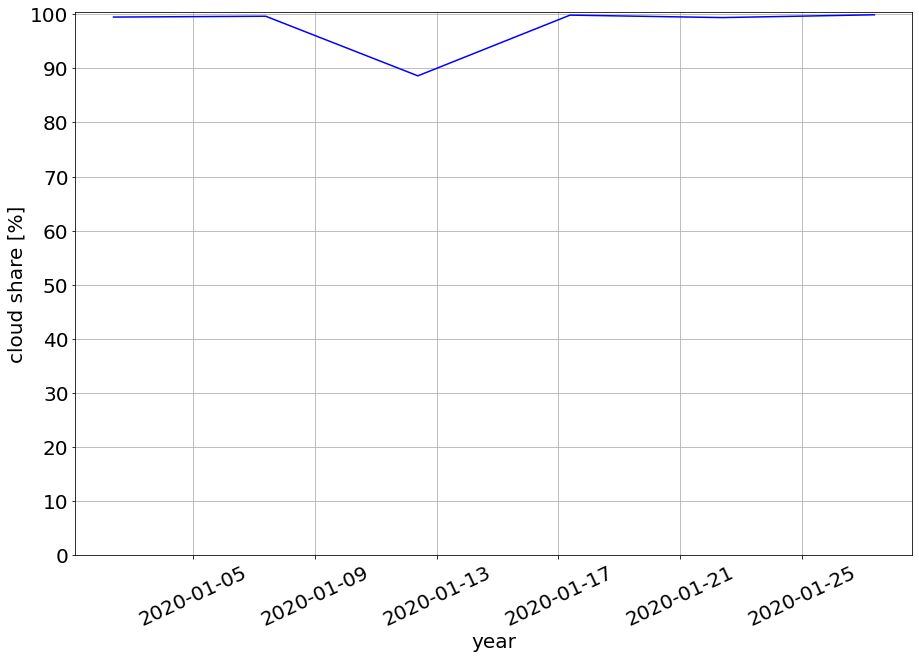

In [19]:
# plotting together
plt.figure(figsize = (15,10))
plt.plot(s2_cct["Acquisition time"], s2_cct["Cloud free pixel[%]"], 'b', markersize=10)
plt.xticks(rotation=25,size=20,)
plt.yticks(list(range(0,109,10)),size=20)
plt.ylabel('cloud share [%]', size=20)
plt.xlabel('year', size=20)
plt.grid(True)

#plt.savefig('Oanob Dam 2020.png')
plt.show()

#### Take a look into scl-band

Clouds are a problem, cloud-masks are useful. But they aren't able to look through clouds. Masks have advantages and disadvantages, i.e. swap ommission with commission errors [(K., Tario et al.)](https://www.sciencedirect.com/science/article/pii/S2666017220300092#fig5).

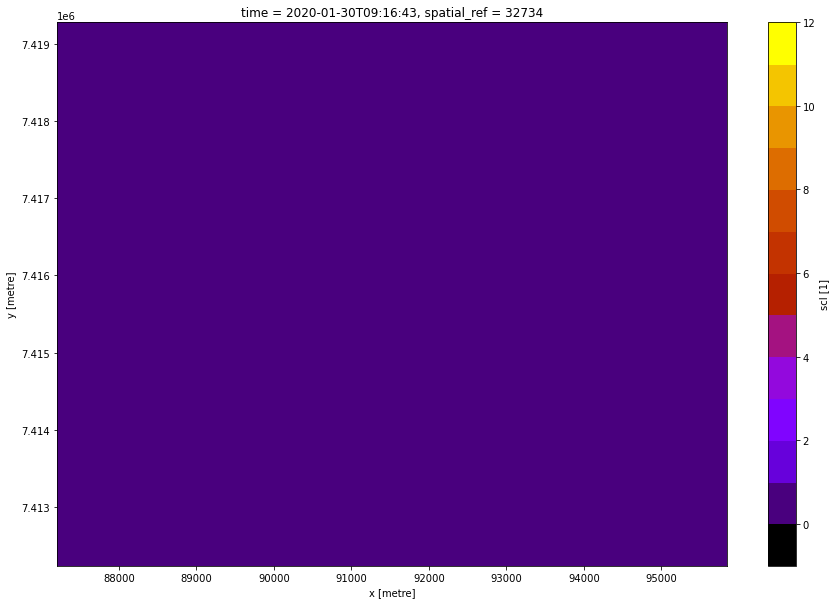

In [20]:
%matplotlib inline
dataset.isel(time=11).scl.plot(cmap='gnuplot', size=10,
                             levels=[-1,0,1,2,3,4,5,6,7,8,9,10,11,12])

### Plot the first image to see what our area looks like
We can use the `rgb` function to plot the first timestep in our dataset as a true colour RGB image:

In [21]:
# Plot as an RGB image
rgb(clean_dataset, index=[0,1,2,3,4,5,6,7,8,9,10], size=5,
   bands=['red_edge1','green','blue'])

IndexError: index 6 is out of bounds for axis 0 with size 6

### WAIT!

Looking at pictures is nice, but we need a deeper understatement of what we are looking at. And we need to control the data we are looking at. For this you can find short overview here: https://science.nasa.gov/ems

## Calculate an index for this area manually
One of the most commonly used remote sensing indices is the Normalised Difference Vegetation Index or `NDVI`. 
This index uses the ratio of the red and near-infrared (NIR) bands to identify live green vegetation.
The formula for NDVI is:

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{(NARROW)NIR} - \text{Red})}{(\text{(NARROW)NIR} + \text{Red})} \\
\end{aligned}
$$

When interpreting this index, high values indicate vegetation, and low values indicate soil or water. It can be useful to look at a hyperspectral labratory dataset like this one:
<img src="../img/hyper.png" width=850px > [source](https://www.researchgate.net/publication/262881350_Remote_detection_of_invasive_plants_A_review_of_spectral_textural_and_phenological_approaches)

<img src="../img/hypex.jpg" width=850px > [source](https://www.sciencedirect.com/science/article/abs/pii/S030324341830504X)

Beside this useful Index, there are many others, which can also be useful in certain cases (see below). The MSI (multispectral instrument), which is the measurement unit on Sentinel-2 satellites, have so called red-edge bands (see figure below, band 5, 6 and 7). They are located between the visible red (4) and the near infrared bands (8 and 8a).


<img src="../img/sentinel_2_channels.png" width=1200px > [source](https://blogs.fu-berlin.de/reseda/sentinel-2/)

### WAIT!

Near Infrared? There are two bands 8?

And what about band 5, 6 and 7?

What about band 9?

[Spectral signatures? ](https://gisgeography.com/spectral-signature/)

### Back to the NDVI

In [ ]:
# Calculate NDVI using the formula above
dataset['ndvi'] = (dataset.narrow_nir - dataset.red) / (dataset.narrow_nir + dataset.red)

# Plot the results for one time step to see what they look like:
dataset.ndvi.isel(time=0).plot(vmin=-0.5, vmax=0.8, cmap='RdYlGn', size=10)

In [ ]:
# Calculate NDVI narrow_nir
dataset['ndvi'] = (dataset.nir - dataset.red) / (dataset.nir + dataset.red)

# Plot the results for one time step to see what they look like:
dataset.ndvi.isel(time=0).plot(vmin=-0.5, vmax=0.75, cmap='RdYlGn', size=10)

In [ ]:
# Calculate NDVI using the formula above
dataset['ndvi'] = (dataset.narrow_nir - dataset.red) / (dataset.narrow_nir + dataset.red)

# Plot the results for one time step to see what they look like:
dataset.ndvi.isel(time=0).plot(vmin=-0.5, vmax=0.8, cmap='RdYlGn', size=10)

In [ ]:
# Use the whole green 
dataset['ndvi'] = (dataset.green - dataset.red) / (dataset.green + dataset.red)

# Plot the results for one time step to see what they look like:
dataset.ndvi.isel(time=0).plot(vmin=-0.5, vmax=0.75, cmap='RdYlGn', size=10)

[Sentinel-2 red-edge position:](https://www.sciencedirect.com/science/article/pii/S092427161300107X)

In [ ]:
# use S2REP, finding a useful part of the index could be tricky, maybe there is none
# 
#((((dataset.nir + dataset.red)/2) − dataset.red_edge1)/(dataset.red_edge2 − dataset.red_edge1)) 
dataset['s2rep'] = 705+35 * ((((dataset.nir + dataset.red)/2) - dataset.red_edge1)/(dataset.red_edge2 - dataset.red_edge1)) 
# Plot the results for one time step to see what they look like:
dataset.s2rep.isel(time=2).plot(vmin=-1, vmax=1, cmap='RdYlGn', size=10)

## Calculate an index for the same area using `s2_indices` function

The `calculate_indices` function provides an easier way to calculate a wide range of remote sensing indices, including:

- **AWEI_ns** (Automated Water Extraction Index,no shadows, Feyisa 2014)
- **AWEI_sh** (Automated Water Extraction Index,shadows, Feyisa 2014)
- **BAEI**    (Built-Up Area Extraction Index, Bouzekri et al. 2015) 
- **BAI**     (Burn Area Index, Martin 1998)
- **BSI**     (Bare Soil Index, Rikimaru et al. 2002)
- **BUI**     (Built-Up Index, He et al. 2010)
- **CMR**     (Clay Minerals Ratio, Drury 1987)
- **EVI**     (Enhanced Vegetation Index, Huete 2002)
- **FMR**     (Ferrous Minerals Ratio, Segal 1982)
- **IOR**     (Iron Oxide Ratio, Segal 1982)  
- **LAI**     (Leaf Area Index, Boegh 2002)
- **MNDWI**   (Modified Normalised Difference Water Index, Xu 1996) 
- **MSAVI**   (Modified Soil Adjusted Vegetation Index, Qi et al. 1994)              
- **NBI**     (New Built-Up Index, Jieli et al. 2010)
- **NBR**     (Normalised Burn Ratio, Lopez Garcia 1991)
- **NDBI**    (Normalised Difference Built-Up Index, Zha 2003)
- **NDCI**    (Normalised Difference Chlorophyll Index, Mishra & Mishra, 2012)
- **NDMI**    (Normalised Difference Moisture Index, Gao 1996)        
- **NDSI**    (Normalised Difference Snow Index, Hall 1995)
- **NDVI**    (Normalised Difference Vegetation Index, Rouse 1973)
- **nNDVI**   (Normalised Difference Vegetation Index using Sentinel-2 band 8a, Rouse 1973)
- **kNDVI**   (Normalised Difference Vegetation Index, Camp-Valls 2021)
- **NDWI**    (Normalised Difference Water Index, McFeeters 1996)
- **SAVI**    (Soil Adjusted Vegetation Index, Huete 1988)
- **TCB**     (Tasseled Cap Brightness, Crist 1985)
- **TCG**     (Tasseled Cap Greeness, Crist 1985)
- **TCW**     (Tasseled Cap Wetness, Crist 1985)
- **WI**      (Water Index, Fisher 2016) 

### Using `s2_indices`, we get the same result (if we are using the same index):

In [ ]:
# Calculate NDVI using `calculate indices`
data_ndvi = s2_indices(dataset, index='kNDVI')

# Plot the results 
data_ndvi.kNDVI.isel(time=0).plot(vmin=0, vmax=0.3, cmap='RdYlGn', size=10)

# <b>Lets make a break or check indices...<b>

### Using calculate_indices to calculate multiple indices at once
The `calculate_indices` function makes it straightforward to calculate multiple remote sensing indices in one line of code.

In the example below, we will calculate `NDVI` as well as two common water indices: the Normalised Difference Water Index (`NDWI`), and the Modified Normalised Difference Index (`MNDWI`).
The new indices will appear in the list of `data_variables` below:

In [ ]:
# Calculate multiple indices
dataset_multi = s2_indices(dataset, index=['nNDVI', 'NDVI', 'MNDWI', 'NDWI'])
dataset_multi

### Dropping original bands from a dataset
We can also drop the original satellite bands from the dataset using `drop=True`. 
The dataset produced below should now only include the new `'NDVI', 'NDWI', 'MNDWI'` bands under `data_variables`:

In [ ]:
## you can build a backup if needed
# testset = dataset

In [ ]:
# Calculate multiple indices and drop original bands
dataset_drop = s2_indices(dataset, 
                            index=['NDVI', 'NDWI', 'MNDWI'], 
                            drop=True)
dataset_drop

### Calculating indices in-place to reduce memory usage for large datasets
By default, the `s2_indices` function will create a new copy of the original data that contains the newly generated remote sensing indices.
This can be problematic for large datasets, as this effectively doubles the amount of data that is stored in memory.

To calculate remote sensing indices directly in-place within the original dataset without copying the data, we can run the function with the parameter `inplace=True`. 
Note that we don't need to assign any output for the function, as the changes will be made to the original data.

In [ ]:
# Calculate index in place without copying data
s2_indices(dataset, 
                  index=['TCW'], 
                  inplace=True)
dataset

### Water mask using the Wofs 
[Muller et al.](https://www.sciencedirect.com/science/article/pii/S0034425715301929) show the potential of Landsat imagery for long-term analysis of water. [Getting Landsat](https://earthexplorer.usgs.gov/) data isn't the biggest problem, as well as the amount of data compared to the Copernicus project. Lets try it with Sentinel-2.

In [ ]:
wofs = wofs_classify(dataset)

### Export as cloud-optimized geo-tiff

In [ ]:
from datacube.utils.cog import write_cog

In [ ]:
write_cog(geo_im=dataset.isel(time=0).to_array(),
         fname='test.tiff')

### Animation

In [ ]:
from tools.plotting import xr_animation

In [ ]:
xr_animation(ds=clean_dataset, 
             output_path='animated_timeseries.gif',
             interval=500,
             bands='blue', 
             show_text='Blue',
             imshow_kwargs={'cmap': 'Blues', 'vmin': 0, 'vmax': 1000},
             width_pixels=500) 

plt.close()

---

## Additional information
## Here the original DEA licenses are shown

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Last modified:** May 2020

**Compatible datacube version:**

In [ ]:
print('ODC version:',datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)